# Sentiment Analysis - Cronos
In this notebook I will be making an sentiment analysis of the Cronos Group, that we scraped from various websites. I will be using two different techniques, to compare the acurracy of both the analysis.

1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of Words approach
2. Roberta Pretrained Model from 🤗
3. Hugging Face Pipeline

For more information on the used techniques:
- [VADER](https://github.com/cjhutto/vaderSentiment)
- [Hugging Face](https://huggingface.co/models)

## Step 0 - Import packages, read in data & NLTK basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

c:\Users\Rehtse Put\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\rcmod.py:4: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion


Reading in the data and getting the first 5 rows

In [2]:
df = pd.read_csv('./cronos_reviews.csv')
df.head(5)

,id,company,date,opinion,rating,source
0,0,your oxygen,14/02/2015,December 2014 ben ik bij Your Oxygen ingeschre...,4.0,facebook
1,1,ARXUS INC.,29/04/2018,Custom professional IT solutions.,5.0,google
2,2,ARXUS INC.,29/04/2017,Belgian cloud at its best!,5.0,google
3,3,ARXUS INC.,29/04/2018,Fast growing company with motivated people. K...,5.0,google
4,4,ASTENA,2021-10-29,Ok,5.0,google


Checking the first opinion

In [34]:
df['opinion'].values[0]

'December 2014 ben ik bij Your Oxygen ingeschreven, ze hadden me gecontacteerd ivm een werknemer van mij voor referenties....aangezien ik toen supervisor was bij Van Moer group. Na jaren dienst was ik toe aan een nieuwe boost en uitdaging in mijn loopbaan! Met dank aan Your Oxygen ben ik nu polyvalent medewerker bij Cogal Belgium Nv(gassector-chemie) met een direct vast bediendencontract en tal van extra legale voordelen'

Looking at the shape of our dataset

In [35]:
print(df.shape)


(380, 6)


### Quick EDA

Here I'm plotting the count of the reviews by stars

<function matplotlib.pyplot.show(close=None, block=None)>

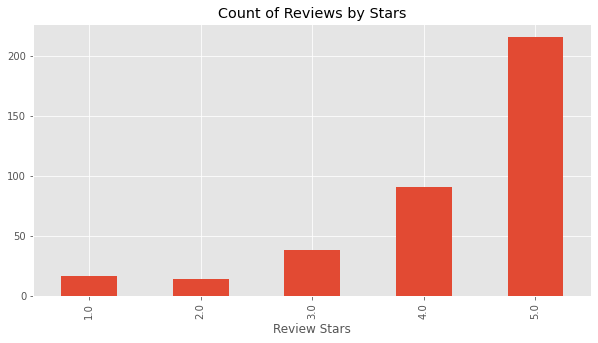

In [36]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar', 
          title='Count of Reviews by Stars', 
          figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show

We can see that the rating is most of the reviews are 4 or 5 star rating. So it's very biased towards positive reviews.

### Basic NLTK

Here I am going to do some basic NLTK, firstly I will do it on 1 example of our dataset

In [6]:

example = df['opinion'][50]
print(example)

Smooth collaboration procedures, minimum interaction, pays on time, helpful., No other interesting clients apart from European institutions


Here I will tokenize the opinion of our example. <br> 
It will just format the opinion so the computer can interpret it. <br>
Basically it just splits the sentence into parts of each word.

In [7]:
tokens = nltk.word_tokenize(example)
tokens[:10] # shows first 10 tokens

['Smooth',
 'collaboration',
 'procedures',
 ',',
 'minimum',
 'interaction',
 ',',
 'pays',
 'on',
 'time']

Part of speech tagging for each token and putting them into entities <br>
More info: [POS Tagging & Chunking](https://www.guru99.com/pos-tagging-chunking-nltk.html)

In [8]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Smooth', 'NNP'),
 ('collaboration', 'NN'),
 ('procedures', 'NNS'),
 (',', ','),
 ('minimum', 'JJ'),
 ('interaction', 'NN'),
 (',', ','),
 ('pays', 'VBZ'),
 ('on', 'IN'),
 ('time', 'NN')]

In [9]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  (GPE Smooth/NNP)
  collaboration/NN
  procedures/NNS
  ,/,
  minimum/JJ
  interaction/NN
  ,/,
  pays/VBZ
  on/IN
  time/NN
  ,/,
  helpful./NN
  ,/,
  (ORGANIZATION No/NNP)
  other/JJ
  interesting/JJ
  clients/NNS
  apart/RB
  from/IN
  (GPE European/JJ)
  institutions/NNS)


## Step 1 - VADER Sentiment Scoring
I used NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the opinion

- VADER uses a "Bag of Words" approach:
  - A text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.
  - Stop words are removed
  - Each word is scored and combined to a total score

Installing the necessary packages for the VADER Sentiment Analysis

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm # Progress bar

sia = SentimentIntensityAnalyzer()

Using some test strings to see how it performs

In [11]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

We can see that it analyses the text to be mostly positive. So it did a great job. <br>
Compound is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive)

In [12]:
sia.polarity_scores('This is the worst thing ever!')

{'neg': 0.468, 'neu': 0.532, 'pos': 0.0, 'compound': -0.6588}

Here the text is mostly negative and neutral and the compound is -0.6588. So it is more negative than positive. <br> 
Which is great because it seems to be working

In [13]:
sia.polarity_scores(example)

{'neg': 0.111, 'neu': 0.754, 'pos': 0.136, 'compound': 0.128}

Running the polarity score on the example

### Running the polarity score on our entire dataset

In [14]:
df.head()

,id,company,date,opinion,rating,source
0,0,your oxygen,14/02/2015,December 2014 ben ik bij Your Oxygen ingeschre...,4.0,facebook
1,1,ARXUS INC.,29/04/2018,Custom professional IT solutions.,5.0,google
2,2,ARXUS INC.,29/04/2017,Belgian cloud at its best!,5.0,google
3,3,ARXUS INC.,29/04/2018,Fast growing company with motivated people. K...,5.0,google
4,4,ASTENA,2021-10-29,Ok,5.0,google


Applying the polarity score to each opinion in our dataset. <br>
Then storing the scores in a dictionary

In [17]:
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['opinion']
    my_id = row['id']
    results[my_id] = sia.polarity_scores(text)
    

  0%|          | 0/380 [00:00<?, ?it/s]

Flipping the vaders score, so we can merge it to our existing dataframe

In [31]:
vaders = pd.DataFrame(results).T # flipping the dataset
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(df, how='left')

In [33]:
vaders.head()

,id,neg,neu,pos,compound,company,date,opinion,rating,source
0,0,0.0,0.957,0.043,0.4574,your oxygen,14/02/2015,December 2014 ben ik bij Your Oxygen ingeschre...,4.0,facebook
1,1,0.0,0.638,0.362,0.1779,ARXUS INC.,29/04/2018,Custom professional IT solutions.,5.0,google
2,2,0.0,0.471,0.529,0.6696,ARXUS INC.,29/04/2017,Belgian cloud at its best!,5.0,google
3,3,0.0,0.643,0.357,0.6114,ARXUS INC.,29/04/2018,Fast growing company with motivated people. K...,5.0,google
4,4,0.0,0.000,1.000,0.2960,ASTENA,2021-10-29,Ok,5.0,google


Now we have the sentiment score and metadata added to our dataset

### Plotting VADER results

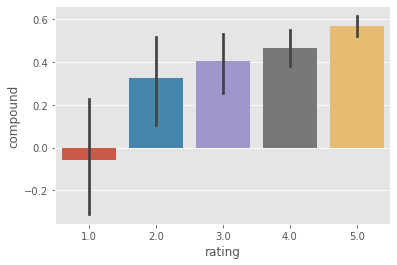

In [38]:
sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compound score by Rating')
plt.show()

A 1 star review on our dataset has a lower compound score and a 5 star review has a higher compound score. Which is what we expected. The more positive the rating the more positive the compound score.

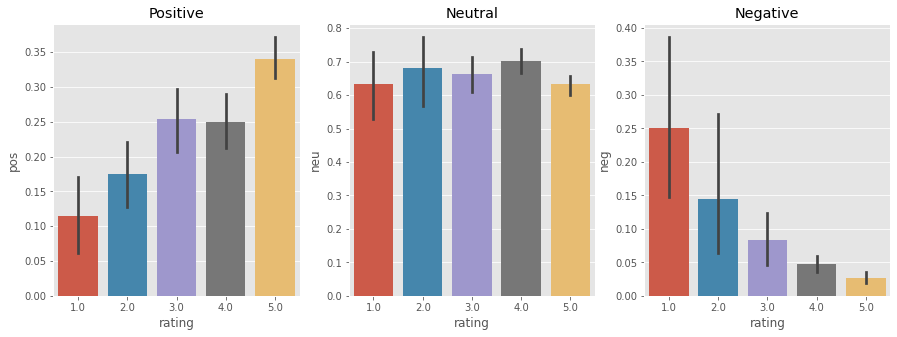

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout
plt.show()

1. The positivity of the opinion gets higher, when the rating gets higher
2. Neutral is mostly flat 
3. Negativity goes down, the opinion gets lower when the rating gets lower

This is all as expected. It's great to see this, because VADER in proving to see the relation between the sentiment score and the rating the users gave.

## Step 2 - Roberta Pretrained Model - Transformer model
The VADER MODEL will not look at the context of the sentences, it will just look at the individual words. <br>

- It will use a model trained of a large corpus of data (a collection of linguistic data (usually contained in a computer database) used for research, scholarship, and teaching)
- Transformer model will account for the words but also the contect related to the other words


In [ ]:
from transformers import AutoTokenizer
